In [131]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [132]:
# Parameters
alpha = 0.5  # Thermal diffusivity
length = 1.0  # Length of the rod
time_end = 1  # End time
num_points = 30  # Number of spatial points
num_steps = 1000  # Number of time steps

In [133]:
# Spatial and time step sizes
dx = length / (num_points - 1)
dt = time_end / num_steps

In [134]:
# Initial condition
initial_temperature = np.zeros(num_points)

In [135]:
# Set one end at 25 degrees and the other end at 600 degrees
initial_temperature[0] = 100.0  # Set the first element (one end) to 25 degrees
initial_temperature[-1] = 600.0  # Set the last element (other end) to 600 degrees


In [136]:
# Initialize temperature array
temperature = initial_temperature.copy()

In [137]:
# Store temperature at each time step
time_steps = np.linspace(0, time_end, num_steps + 1)
temperature_history = [temperature.copy()]


In [138]:
# Finite difference method
for n in range(1, num_steps + 1):
    # Compute new temperature values using finite difference
    temperature[1:-1] = (
        temperature[1:-1]
        + alpha * dt / dx**2 * (temperature[2:] - 2 * temperature[1:-1] + temperature[:-2])
    )
    # Store the temperature at this time step
    temperature_history.append(temperature.copy())


In [139]:
# Plot the results
plt.figure(figsize=(10, 6))


<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

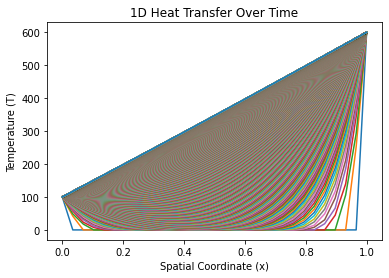

In [140]:
# Plot spatial variation at different time steps
for i, time_step in enumerate(time_steps):
    plt.plot(np.linspace(0, length, num_points), temperature_history[i], label=f'Time = {time_step:.2f}')

plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Temperature (T)')
plt.title('1D Heat Transfer Over Time')
#plt.legend()
plt.show()

In [141]:
# Save data to CSV file
csv_filename = 'heat_transfer_data_with_time.csv'

with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Spatial Coordinate (x)', *time_steps])
    csv_writer.writerows(np.column_stack((np.linspace(0, length, num_points), *temperature_history)))

print(f'Data saved to {csv_filename}')

Data saved to heat_transfer_data_with_time.csv
